In [1]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess, icews
from models import spot
from models.networks import FCNetwork, train_encoder

# stats
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'

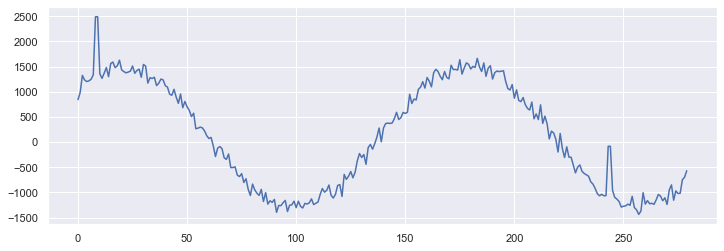

In [3]:
synth_df = pd.read_csv('data/synthetic_10.txt')
synth_tensor = torch.tensor(synth_df.value)[650:930]
sns.lineplot(data=synth_tensor);

In [4]:
# Cut time series into 7 step subsequences
seqs = preprocess.sequence(synth_tensor, 7)

# Create a simple pytorch datast
# transform = preprocess.Difference()
dataset = data.SimpleDataset(seqs, transform=None)

# and DataLoader
dataloader = DataLoader(dataset, shuffle=True)

In [5]:
# Create a dense network architecture
window = 7
hidden_layers = (100,)
model = FCNetwork(window, hidden_layers, window)

In [13]:
# train network
lr = 1e-5
loss = train_encoder(model, 
                     epochs=5000, 
                     trainload=dataloader, 
                     lr=lr,
                     LSTM=False)

Training model on cpu


  0%|          | 0/5000 [00:00<?, ?it/s]

<AxesSubplot:>

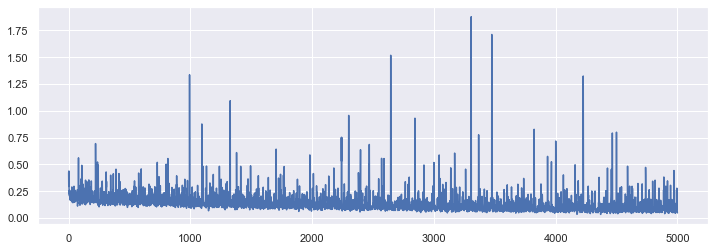

In [14]:
sns.lineplot(data=loss[0])

## Inference on dataset

In [15]:
with torch.no_grad():
    reconstructed = torch.tensor([])
    for x in dataset:
        x_hat = model(x)
#         x_hat = transform.inverse(x_hat)
        reconstructed = torch.cat((reconstructed, x_hat))
    
reconstructed = reconstructed.view(-1)

## Compute Anomaly Scores

In [16]:
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, synth_tensor)

In [17]:
cdf = ECDF(loss)
thresh = next(x for x in cdf(loss) if x > 0.99)

## Visualize Anomaly Scores

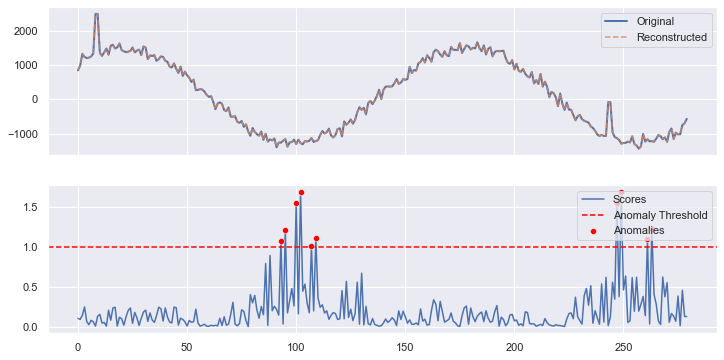

In [18]:
# get x, y coordinates for plotting anoms.
x = np.where(loss > thresh)[0]
y = loss[loss > thresh]

fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=synth_tensor, linestyle='-', linewidth=2, ax=ax[0], label="Original")
sns.lineplot(data=reconstructed, linestyle='--', alpha=0.8, ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=loss, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()

In [ ]:
torch.save(model.state_dict(), f'models/dense_lr={lr}_{hidden_layers}.pt')

In [19]:
loss.mean()

tensor(0.1954, dtype=torch.float64)